In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#liblaries for ML
from scipy import stats
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
URL = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv'

req = requests.get(URL)

req.headers

{'Connection': 'keep-alive', 'Content-Length': '154500', 'Cache-Control': 'max-age=300', 'Content-Security-Policy': "default-src 'none'; style-src 'unsafe-inline'; sandbox", 'Content-Type': 'text/plain; charset=utf-8', 'ETag': 'W/"d901e6fe53bcc43168991cd6d6156d10a1dc274f9088d941dfbe6520d54137fc"', 'Strict-Transport-Security': 'max-age=31536000', 'X-Content-Type-Options': 'nosniff', 'X-Frame-Options': 'deny', 'X-XSS-Protection': '1; mode=block', 'X-GitHub-Request-Id': '2F81:1113:C6FEE:CF44E:674619BD', 'Content-Encoding': 'gzip', 'Accept-Ranges': 'bytes', 'Date': 'Tue, 26 Nov 2024 19:27:28 GMT', 'Via': '1.1 varnish', 'X-Served-By': 'cache-bfi-kbfi7400078-BFI', 'X-Cache': 'HIT', 'X-Cache-Hits': '0', 'X-Timer': 'S1732649248.883325,VS0,VE141', 'Vary': 'Authorization,Accept-Encoding,Origin', 'Access-Control-Allow-Origin': '*', 'Cross-Origin-Resource-Policy': 'cross-origin', 'X-Fastly-Request-ID': '79e847784db1eaa075be83ebbb0d0078d118e759', 'Expires': 'Tue, 26 Nov 2024 19:32:28 GMT', 'Source-

In [3]:
match req.status_code:
    case 200:
        print(req)
    case 404:
        raise 'Problem with connection'
    case _ :
        raise f'Something wrong {req.status_code}'
print(req.status_code)

<Response [200]>
200


In [4]:
df = pd.read_csv(URL, sep = ',')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3694 non-null   int64  
 1   item_id            3694 non-null   int64  
 2   name               3694 non-null   object 
 3   category           3694 non-null   object 
 4   price              3694 non-null   float64
 5   old_price          3694 non-null   object 
 6   sellable_online    3694 non-null   bool   
 7   link               3694 non-null   object 
 8   other_colors       3694 non-null   object 
 9   short_description  3694 non-null   object 
 10  designer           3694 non-null   object 
 11  depth              2231 non-null   float64
 12  height             2706 non-null   float64
 13  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 378.9+ KB


Колонка 'Unnamed: 0' виглядає як індекс, тому її можна видалити.

In [6]:
df = df.drop(columns=['Unnamed: 0'])

In [7]:
df.shape

(3694, 13)

In [8]:
df.columns

Index(['item_id', 'name', 'category', 'price', 'old_price', 'sellable_online',
       'link', 'other_colors', 'short_description', 'designer', 'depth',
       'height', 'width'],
      dtype='object')

Короткі статистичні дані по всьому дата сету.

In [9]:
df.describe()

,item_id,price,depth,height,width
count,3.694000e+03,3694.000000,2231.000000,2706.000000,3105.000000
mean,4.863240e+07,1078.208419,54.379202,101.679970,104.470853
std,2.888709e+07,1374.652494,29.958351,61.097585,71.133771
min,5.848700e+04,3.000000,1.000000,1.000000,1.000000
25%,2.039057e+07,180.900000,38.000000,67.000000,60.000000
50%,4.928808e+07,544.700000,47.000000,83.000000,80.000000
75%,7.040357e+07,1429.500000,60.000000,124.000000,140.000000
max,9.993262e+07,9585.000000,257.000000,700.000000,420.000000


Щоб знайти дублікати, ми можемо перевірити, чи є ідентичні записи. Зазвичай дублікати можуть бути через невеликі варіації в даних

In [10]:
duplicates = df[df.duplicated()]
print(f"Кількість повних дублікатів: {len(duplicates)}")

Кількість повних дублікатів: 0


Для виявлення сутнісних дублікатів потрібно звернути увагу на item_id, тому що це унікальний ідентифікатор товару. Можна перевірити, чи є товар з різними цінами або іншими характеристиками.

In [11]:
item_id_duplicates = df[df.duplicated(subset=['item_id'], keep=False)]
print(f"Кількість дублікованих item_id: {len(item_id_duplicates)}")
item_id_duplicates.sort_values(by='item_id')

Кількість дублікованих item_id: 1352


,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
1918,91415,TROFAST,Nursery furniture,5.0,No old price,True,https://www.ikea.com/sa/en/p/trofast-lid-white...,No,"Lid, 20x28 cm",Studio Copenhagen,NaN,NaN,28.0
1834,91415,TROFAST,Children's furniture,5.0,No old price,True,https://www.ikea.com/sa/en/p/trofast-lid-white...,No,"Lid, 20x28 cm",Studio Copenhagen,NaN,NaN,28.0
151,102065,LYCKSELE LÖVÅS,Beds,495.0,No old price,True,https://www.ikea.com/sa/en/p/lycksele-loevas-m...,No,"Mattress, 140x188 cm",IKEA of Sweden,NaN,NaN,NaN
2560,102065,LYCKSELE LÖVÅS,Sofas & armchairs,495.0,No old price,True,https://www.ikea.com/sa/en/p/lycksele-loevas-m...,No,"Mattress, 140x188 cm",IKEA of Sweden,NaN,NaN,NaN
2178,105064,LIATORP,"Sideboards, buffets & console tables",445.0,No old price,True,https://www.ikea.com/sa/en/p/liatorp-console-t...,No,"Console table, 133x37 cm",Carina Bengs,NaN,75.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,99323614,SMÅGÖRA,Nursery furniture,370.0,No old price,True,https://www.ikea.com/sa/en/p/smagoera-changing...,No,Changing tbl/bookshelf w 1 shlf ut,IKEA of Sweden,40.0,91.0,60.0
3028,99323925,STENSELE,Tables & desks,550.0,No old price,True,https://www.ikea.com/sa/en/p/stensele-bar-tabl...,No,"Bar table, 70x70 cm",Maja Ganszyniec,NaN,104.0,70.0
29,99323925,STENSELE,Bar furniture,550.0,No old price,True,https://www.ikea.com/sa/en/p/stensele-bar-tabl...,No,"Bar table, 70x70 cm",Maja Ganszyniec,NaN,104.0,70.0
2737,99902661,VITTSJÖ,Tables & desks,609.0,No old price,True,https://www.ikea.com/sa/en/p/vittsjoe-shelving...,No,"Shelving unit with laptop table, ...",Johan Kroon,36.0,NaN,202.0


Перевіряємо чи видалили дублікати

In [12]:
missing_values = df.isnull().sum()
print(f"Пропуски в даних:\n{missing_values}")

Пропуски в даних:
item_id                 0
name                    0
category                0
price                   0
old_price               0
sellable_online         0
link                    0
other_colors            0
short_description       0
designer                0
depth                1463
height                988
width                 589
dtype: int64


Відсутні значення є в важливих стовпцях, їх можна або заповнити медіаною

In [13]:
df['depth'] = df['depth'].fillna(df['depth'].median())
df['height'] = df['height'].fillna(df['height'].median())
df['width'] = df['width'].fillna(df['width'].median())

In [14]:
df.old_price.unique()

array(['No old price', 'SR 2,375', 'SR 295', 'SR 175', 'SR 995',
       'SR 1,385', 'SR 445', 'SR 925', 'SR 2,205', 'SR 895', 'SR 2,435',
       'SR 125', 'SR 1,595', 'SR 2,880', 'SR 940', 'SR 800', 'SR 1,995',
       'SR 3,245', 'SR 8,735', 'SR 2,310', 'SR 2,560', 'SR 3,760',
       'SR 3,130', 'SR 9,745', 'SR 1,885', 'SR 3,265', 'SR 50/4 pack',
       'SR 1,450', 'SR 250', 'SR 1,590', 'SR 2,360', 'SR 4,040',
       'SR 1,715', 'SR 2,100', 'SR 2,395', 'SR 1,250', 'SR 5,610',
       'SR 7,225', 'SR 2,795', 'SR 8,540', 'SR 1,950', 'SR 5,400',
       'SR 375', 'SR 5,045', 'SR 5,640', 'SR 3,665', 'SR 2,095',
       'SR 2,495', 'SR 9,430', 'SR 6,530', 'SR 138', 'SR 350', 'SR 1,023',
       'SR 437', 'SR 1,390', 'SR 50', 'SR 595', 'SR 275', 'SR 395',
       'SR 26', 'SR 695', 'SR 645', 'SR 649', 'SR 232', 'SR 750', 'SR 30',
       'SR 892', 'SR 10', 'SR 490', 'SR 4,185', 'SR 655', 'SR 27',
       'SR 455', 'SR 7', 'SR 657', 'SR 1,120', 'SR 237', 'SR 22',
       'SR 1,180', 'SR 15', 'SR 10/4

In [15]:
# Функція для очищення старих цін
def clean_old_price(price_str):
    if price_str == "No old price":
        return np.nan  # Заміщаємо на NaN для відсутніх цін
    price_str = price_str.replace("SR", "").replace(",", "").strip()  # Видаляємо символ валюти та коми
    # Перевіряємо, чи є в рядку кілька слів (наприклад, "50/4 pack") і залишаємо тільки число
    price_str = ''.join([char for char in price_str if char.isdigit() or char == '.'])
    try:
        return float(price_str)  # Перетворюємо на число
    except ValueError:
        return np.nan  # Якщо неможливо перетворити, повертаємо NaN

# Очищення колонки 'old_price'
df['old_price'] = df['old_price'].apply(clean_old_price)

# Перевірка результату
print(df)

       item_id                   name       category   price  old_price  \
0     90420332               FREKVENS  Bar furniture   265.0        NaN   
1       368814              NORDVIKEN  Bar furniture   995.0        NaN   
2      9333523  NORDVIKEN / NORDVIKEN  Bar furniture  2095.0        NaN   
3     80155205                   STIG  Bar furniture    69.0        NaN   
4     30180504                NORBERG  Bar furniture   225.0        NaN   
...        ...                    ...            ...     ...        ...   
3689  99157902                ELVARLI      Wardrobes   750.0      820.0   
3690   9158152                ELVARLI      Wardrobes  1572.0     1755.0   
3691  59157541                ELVARLI      Wardrobes   924.0     1050.0   
3692  89157573                ELVARLI      Wardrobes  2745.0     3130.0   
3693  69157376                ELVARLI      Wardrobes  1231.0     1535.0   

      sellable_online                                               link  \
0                True  

In [20]:
print('\nІнформація про дизайнерів')
print(df['designer'].describe())
print('\nУнікальні значення')
print(df.designer.unique())
print(df['designer'].value_counts().sort_values(ascending=False))
df['designer_len'] = [len(x) for x in df['designer']]
print(df['designer_len'].value_counts().sort_values())
print(df.sort_values(by='designer_len', ascending=False).head(25))


Інформація про дизайнерів
count               3694
unique               381
top       IKEA of Sweden
freq                 828
Name: designer, dtype: object

Унікальні значення
['Nicholai Wiig Hansen' 'Francis Cayouette' 'Henrik Preutz'
 'Marcus Arvonen' 'Carina Bengs' 'K Hagberg/M Hagberg' 'Sarah Fager'
 'Ehlén Johansson' 'Nike Karlsson' 'Maja Ganszyniec' 'Karl Malmvall'
 'John/Jonas/Petrus/Paul/Caroline' 'Nike Karlsson/Maja Ganszyniec'
 'J Karlsson/N Karlsson' 'IKEA of Sweden/Karl Malmvall' 'IKEA of Sweden'
 'Nike Karlsson/J Karlsson/N Karlsson' 'Ola Wihlborg'
 'IKEA of Sweden/Tina Christensen' 'IKEA of Sweden/K Hagberg/M Hagberg'
 'Ola Wihlborg/IKEA of Sweden'
 '504.689.53 Small and easy-to-place chair-bed which can easily be converted into a single bed.The storage space under the seat has room for bedlinen or other things.Just as nice to look at from all sides – perfect to place in the middle of the room or use as a room divider.The cushion cover is easy to keep clean and fresh, as

Очищуємо колонку дизайренів

In [22]:
def cleanDesigner(value, removeIKEA=False, emptyValue=np.nan):
    if not isinstance(value, str):
      return value
    if len(value)>0 and value[0].isdigit():
      return emptyValue

    designers = value.split("/")

    if removeIKEA:
        try:
           designers.remove("IKEA of Sweden")
        except:
           pass
    if len(designers)>0:
       return '/'.join(sorted(designers))
    else:
       return emptyValue

df['designer_clean'] = df['designer'].apply(cleanDesigner, args=(False, "IKEA of Sweden"))



In [23]:
median_price_by_designer = df.groupby('designer_clean')['price'].median()

# Виведення результату
print(median_price_by_designer)

designer_clean
A Fredriksson/H Preutz                                   35.0
A Fredriksson/HAY/J Hultqvist/W Chong                  2575.0
A Fredriksson/IKEA of Sweden/J Hultqvist/W Chong        675.0
A Fredriksson/J Hultqvist/Lisa Norinder/W Chong         889.0
A Fredriksson/J Hultqvist/Mikael Warnhammar/W Chong    2575.0
                                                        ...  
Tina Christensen                                        550.0
Tom Dixon                                              1047.5
Tord Björklund                                          500.0
Virgil Abloh                                            480.0
Wiebke Braasch                                          410.0
Name: price, Length: 199, dtype: float64


top_15_designers


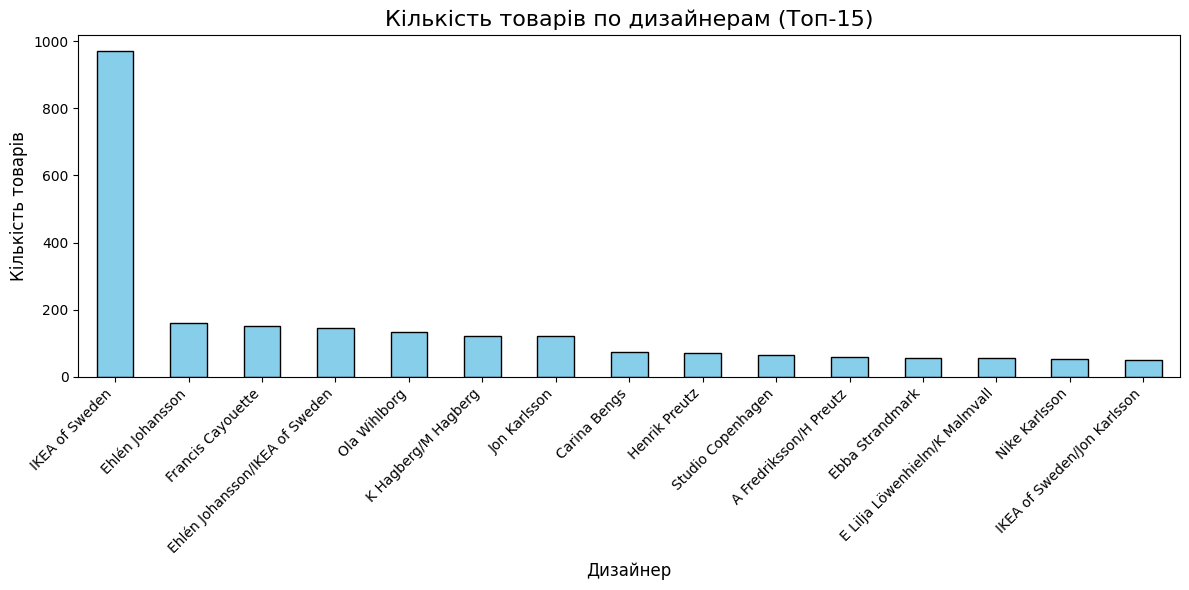

In [26]:
designer_count = df['designer_clean'].value_counts()

# Вибираємо топ-15 дизайнерів
top_15_designers = designer_count.head(15)

# Створення стовпчикового графіку для топ-15 дизайнерів
plt.figure(figsize=(12, 6))
top_15_designers.plot(kind='bar', color='skyblue', edgecolor='black')

# Налаштування графіку
plt.title('Кількість товарів по дизайнерам (Топ-15)', fontsize=16)
plt.xlabel('Дизайнер', fontsize=12)
plt.ylabel('Кількість товарів', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Кількість товарів')

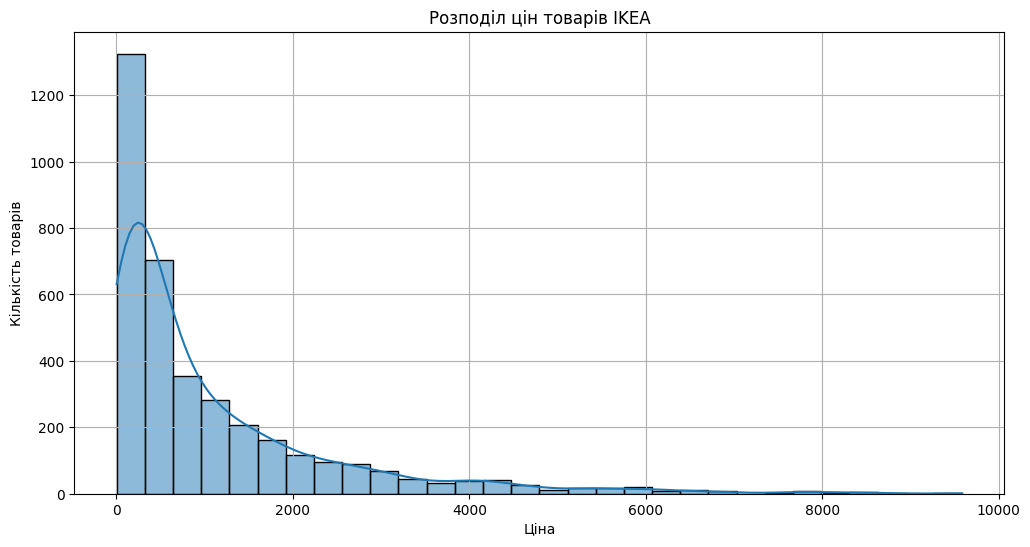

In [27]:
plt.figure(figsize=(12,6))
sns.histplot(df['price'], bins=30, kde=True)
plt.grid(True)
plt.title('Розподіл цін товарів IKEA')
plt.xlabel('Ціна')
plt.ylabel('Кількість товарів')

In [28]:
median_prices_cat = df.groupby('category')['price'].median()
sorted_median_prices_cat = median_prices_cat.sort_values(ascending=False)
print(sorted_median_prices_cat)

category
Wardrobes                               1870.0
Sofas & armchairs                       1268.5
Beds                                    1093.5
Sideboards, buffets & console tables     965.0
Room dividers                            725.0
Tables & desks                           595.0
Chests of drawers & drawer units         460.0
Trolleys                                 447.5
Bar furniture                            445.0
Chairs                                   425.0
Café furniture                           424.5
Cabinets & cupboards                     402.0
Nursery furniture                        350.0
Outdoor furniture                        313.7
Bookcases & shelving units               310.0
Children's furniture                     202.5
TV & media furniture                     175.0
Name: price, dtype: float64


Text(0, 0.5, 'Медіанна ціна')

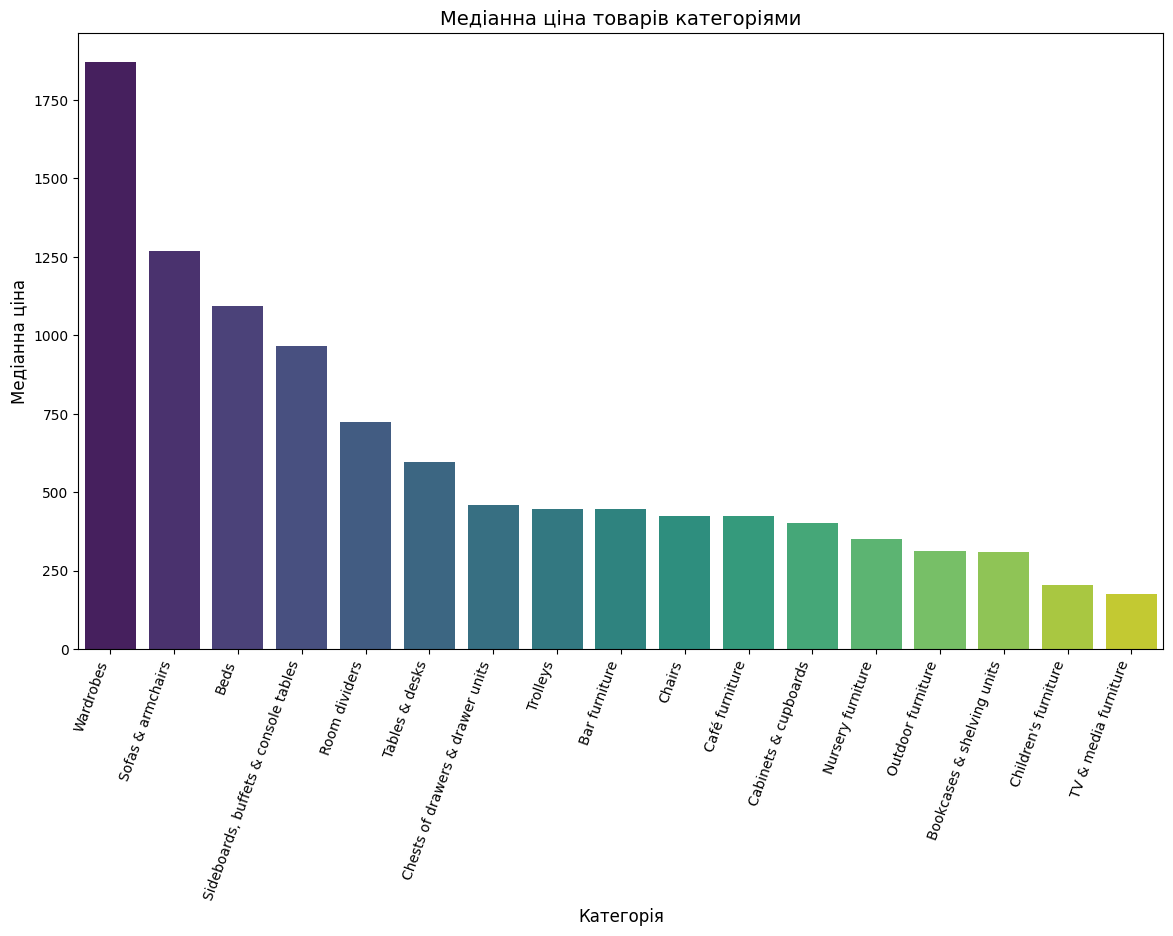

In [29]:
plt.figure(figsize=(14,8))
sns.barplot(x=sorted_median_prices_cat.index, y=sorted_median_prices_cat.values, palette='viridis')

# Додавання заголовка та підписів
plt.title('Медіанна ціна товарів категоріями', fontsize=14)
plt.xlabel('Категорія', fontsize=12)
plt.xticks(rotation=70, ha='right')
plt.ylabel('Медіанна ціна', fontsize=12)

In [30]:
#  Підрахуємо кількість товарів для кожного значення в колонці 'other_colors'
color_counts = df['other_colors'].value_counts()

# Виведемо результат
print("Кількість товарів, які мають інші кольори:", color_counts.get('Yes', 0))
print("Кількість товарів, які не мають інших кольорів:", color_counts.get('No', 0))

Кількість товарів, які мають інші кольори: 1512
Кількість товарів, які не мають інших кольорів: 2182


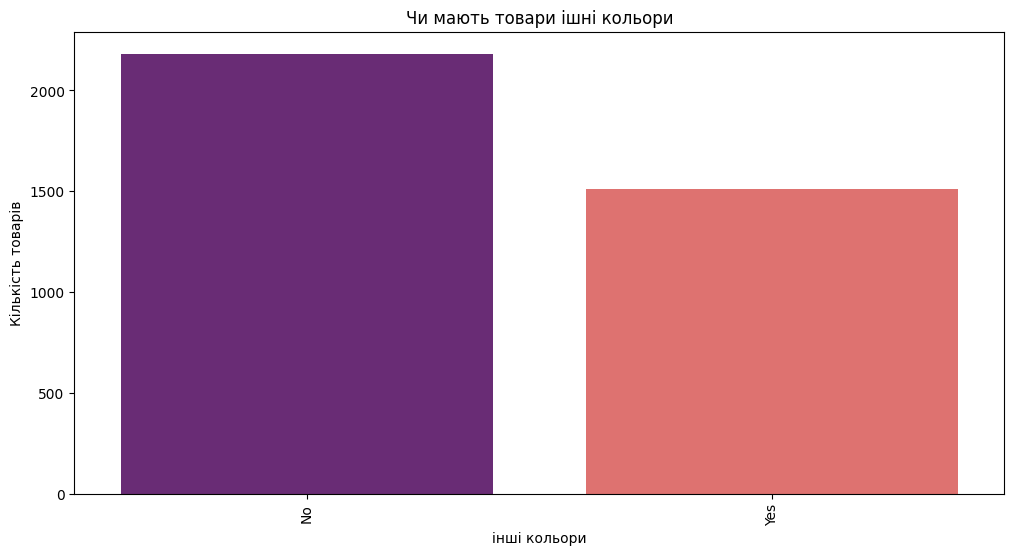

In [31]:
plt.figure(figsize=(12, 6))
sns.countplot(x='other_colors', data=df, palette='magma')
plt.title('Чи мають товари ішні кольори')
plt.xticks(rotation=90)
plt.xlabel('інші кольори')
plt.ylabel('Кількість товарів')
plt.show()

other_colors
No     450.0
Yes    672.5
Name: price, dtype: float64


Text(0, 0.5, 'Медіанна ціна')

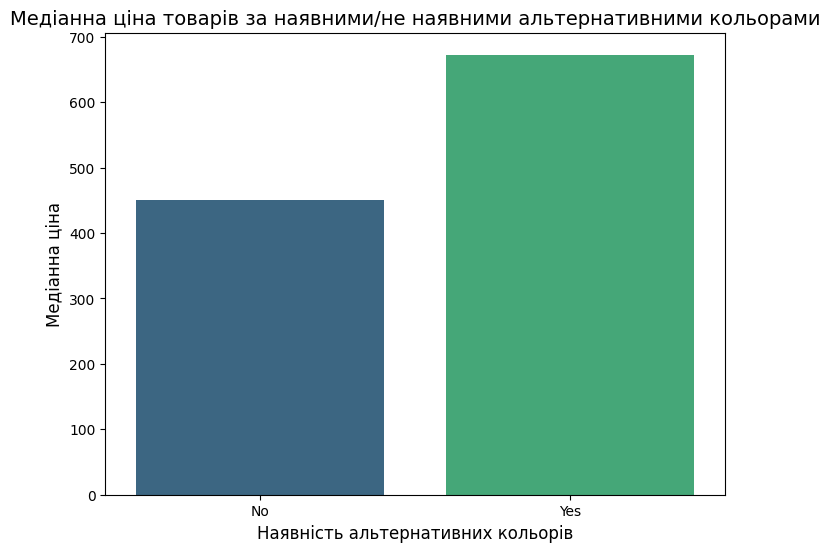

In [32]:
median_price_by_colors = df.groupby('other_colors')['price'].median()
print(median_price_by_colors)
plt.figure(figsize=(8,6))
sns.barplot(x=median_price_by_colors.index, y=median_price_by_colors.values, palette='viridis')

# Додавання заголовка та підписів
plt.title('Медіанна ціна товарів за наявними/не наявними альтернативними кольорами', fontsize=14)
plt.xlabel('Наявність альтернативних кольорів', fontsize=12)
plt.ylabel('Медіанна ціна', fontsize=12)

Перевіримо, чи є залежність між габаритами товарів (глибина, висота, ширина) та їх ціною.

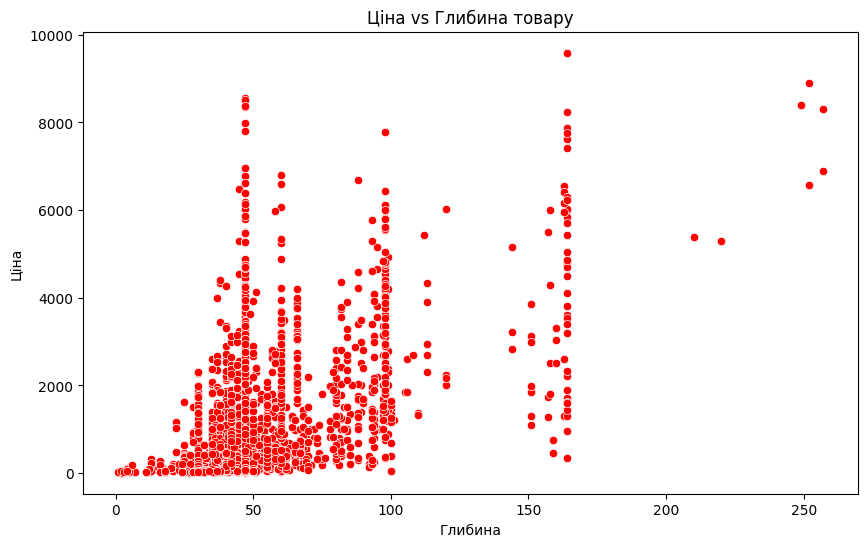

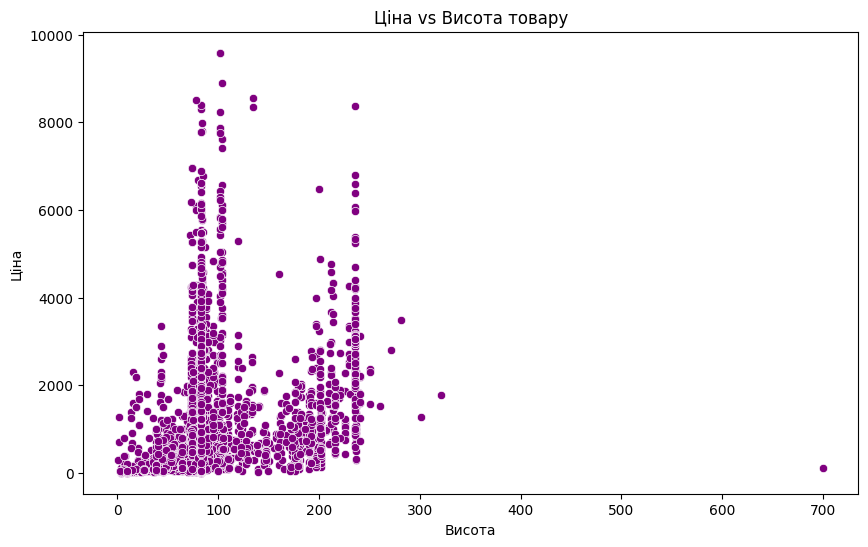

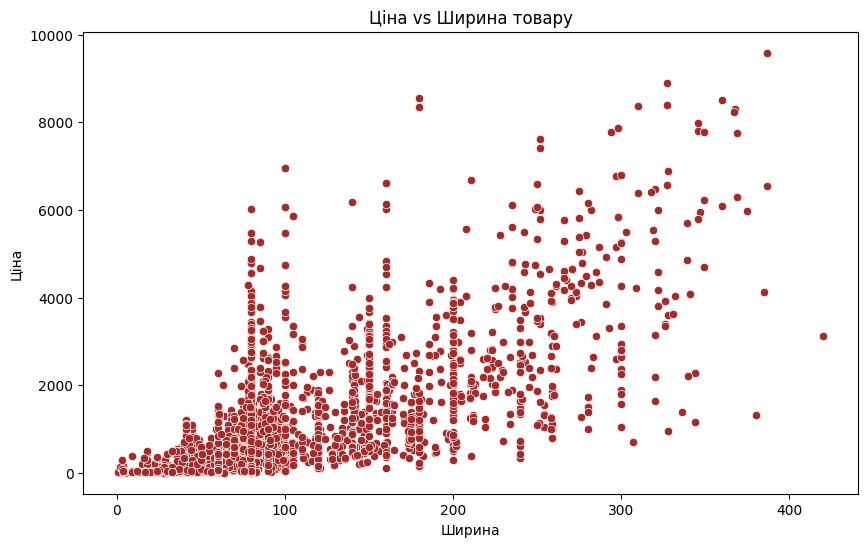

In [33]:
# Розподіл ціни в залежності від глибини товару
plt.figure(figsize=(10, 6))
sns.scatterplot(x='depth', y='price', data=df, color='red')
plt.title('Ціна vs Глибина товару')
plt.xlabel('Глибина')
plt.ylabel('Ціна')
plt.show()

# Розподіл ціни в залежності від висоти товару
plt.figure(figsize=(10, 6))
sns.scatterplot(x='height', y='price', data=df, color='purple')
plt.title('Ціна vs Висота товару')
plt.xlabel('Висота')
plt.ylabel('Ціна')
plt.show()

# Розподіл ціни в залежності від ширини товару
plt.figure(figsize=(10, 6))
sns.scatterplot(x='width', y='price', data=df, color='brown')
plt.title('Ціна vs Ширина товару')
plt.xlabel('Ширина')
plt.ylabel('Ціна')
plt.show()

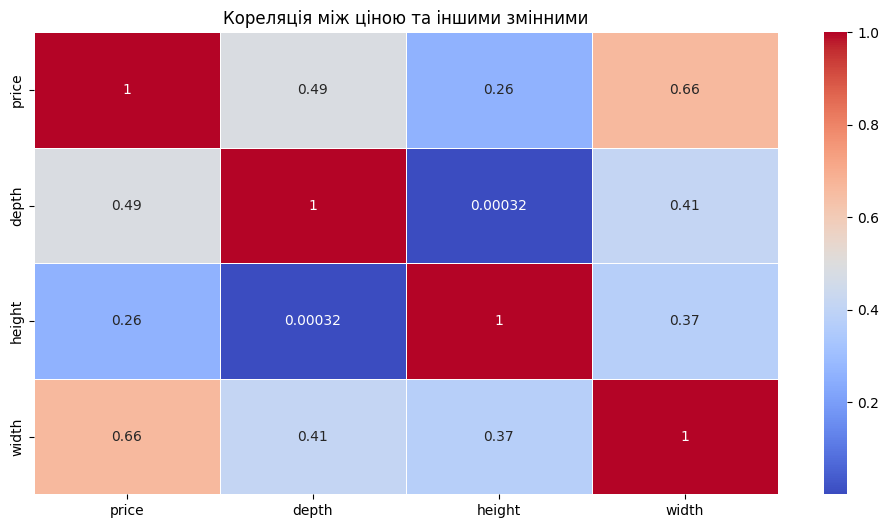

In [34]:
correlation_matrix = df[['price', 'depth', 'height', 'width']].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Кореляція між ціною та іншими змінними')
plt.show()

In [35]:
Q1 = df['price'].quantile(0.25)  # 25-й процентиль
Q3 = df['price'].quantile(0.75)  # 75-й процентиль
IQR = Q3 - Q1

# Обчислюємо межі для виявлення викидів
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фільтруємо викиди
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print(f"Кількість викидів: {len(outliers)}")

Кількість викидів: 276


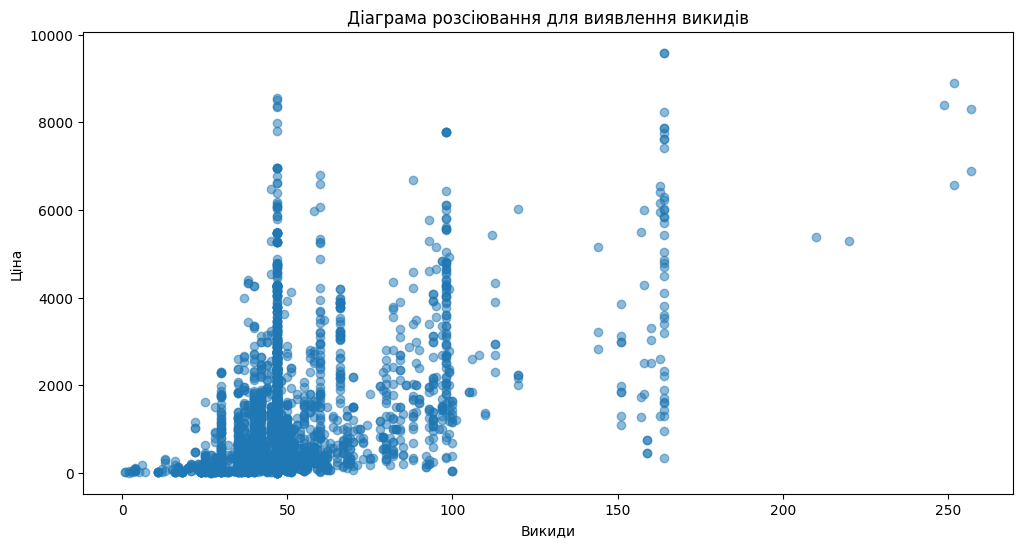

In [36]:
plt.figure(figsize=(12, 6))
plt.scatter(df['depth'], df['price'], alpha=0.5)
plt.title('Діаграма розсіювання для виявлення викидів')
plt.xlabel('Викиди')
plt.ylabel('Ціна')
plt.show()

Нульова гіпотеза (H₀): Ціна товару не залежить від його категорії. (Тобто, середні ціни товарів в різних категоріях не відрізняються.)

Альтернативна гіпотеза (H₁): Ціна товару залежить від його категорії. (Тобто, середні ціни товарів в різних категоріях відрізняються.)

In [37]:
categories = df['category'].unique()

# Створюємо список цін для кожної категорії
prices_by_category = [df[df['category'] == category]['price'].dropna() for category in categories]

# Виконання ANOVA
f_stat, p_value = stats.f_oneway(*prices_by_category)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

# Інтерпретація результату
if p_value < 0.05:
    print("Відкидаємо нульову гіпотезу, ціна залежить від категорії товару.")
else:
    print("Не маємо підстав відкидати нульову гіпотезу, ціни не залежить від категорії товару.")

F-statistic: 44.17597146100269
P-value: 1.7017332054127823e-127
Відкидаємо нульову гіпотезу, ціна залежить від категорії товару.


In [38]:
h_stat, p_value = stats.kruskal(*prices_by_category)

print(f"H-statistic: {h_stat}")
print(f"P-value: {p_value}")

# Інтерпретація результату
if p_value < 0.05:
    print("Відкидаємо нульову гіпотезу, ціна залежить від категорії товару.")
else:
    print("Не маємо підстав відкидати нульову гіпотезу, ціни не залежить від категорії товару.")

H-statistic: 684.7748456684609
P-value: 2.2447596280864974e-135
Відкидаємо нульову гіпотезу, ціна залежить від категорії товару.


Нульова гіпотеза: Об'єм товару (глибина × висота × ширина) не впливає на його ціну.

Альтернативна гіпотеза: Об'єм товару (глибина × висота × ширина)  впливає на його ціну.

In [40]:
df['volume'] = df['depth'] * df['height'] * df['width']

corr, p_value = pearsonr(df['volume'], df['price'])
print(f"Коефіцієнт кореляції: {corr}, P-value: {p_value}")

if p_value < 0.05:
    print("Відкидаємо нульову гіпотезу: об'єм товару впливає на його ціну.")
else:
    print("Не маємо підстав відкидати нульову гіпотезу: об'єм товару не впливає на його ціну.")

Коефіцієнт кореляції: 0.6687002415933941, P-value: 0.0
Відкидаємо нульову гіпотезу: об'єм товару впливає на його ціну.


In [41]:
corr, p_value = spearmanr(df['volume'], df['price'])

print(f"Кореляція Спірмена: {corr}, P-value: {p_value}")

if p_value < 0.05:
    print("Відкидаємо нульову гіпотезу: об'єм товару впливає на його ціну.")
else:
    print("Не маємо підстав відкидати нульову гіпотезу: об'єм товару не впливає на його ціну.")

Кореляція Спірмена: 0.7022649080167598, P-value: 0.0
Відкидаємо нульову гіпотезу: об'єм товару впливає на його ціну.


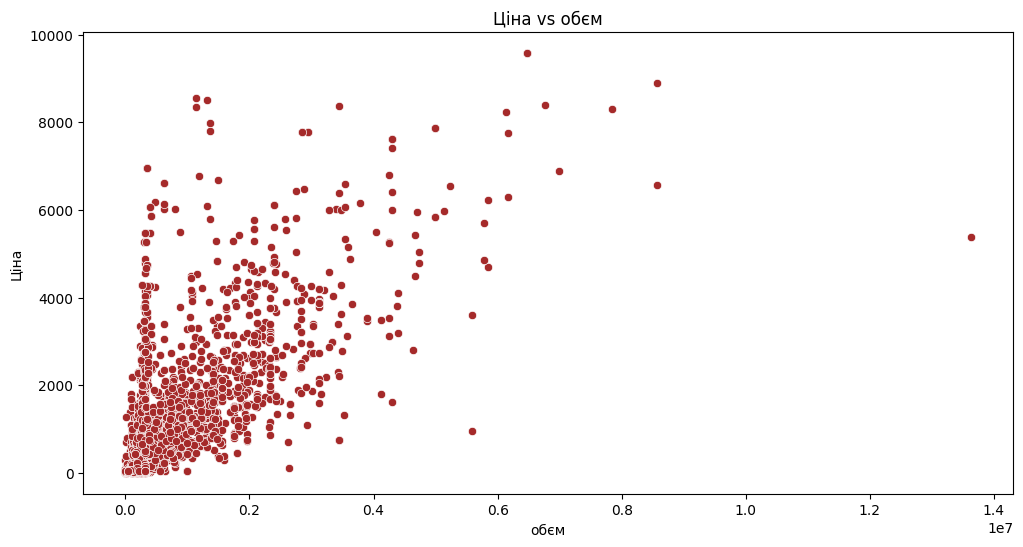

In [42]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='volume', y='price', data=df, color='brown')
plt.title('Ціна vs обєм')
plt.xlabel('обєм')
plt.ylabel('Ціна')
plt.show()

Нульова гіпотеза: Ціна товару не залежить від того, чи доступний він для продажу онлайн.

Альтернативна гіпотеза: Ціна товару залежить від того, чи доступний він для продажу онлайн

In [43]:
# Створюємо дві групи: онлайн-продажі і оффлайн-продажі
group_online = df[df['sellable_online'] == True]['price']
group_offline = df[df['sellable_online'] == False]['price']

# Виконання t-тесту для двох незалежних вибірок
t_stat, p_value = ttest_ind(group_online, group_offline)

print(f"t-statistic: {t_stat}, p-value: {p_value}")

# Перевірка p-value для прийняття або відкидання гіпотези
if p_value < 0.05:
    print("Відкидаємо нульову гіпотезу: ціна товару залежить від того, чи доступний товар для продажу онлайн.")
else:
    print("Не відкидаємо нульову гіпотезу: ціна товару не залежить від того, чи доступний товар для продажу онлайн.")

t-statistic: 2.446164909977735, p-value: 0.014484848977116297
Відкидаємо нульову гіпотезу: ціна товару залежить від того, чи доступний товар для продажу онлайн.


In [44]:
group_online = df[df['sellable_online'] == True]['price']
group_offline = df[df['sellable_online'] == False]['price']

if len(group_online) > 0 and len(group_offline) > 0:
    # Тест Манна-Уітні
    stat, p_value = mannwhitneyu(group_online, group_offline)

    print(f"Statistic: {stat}, p-value: {p_value}")

    # Перевірка p-value для прийняття або відкидання гіпотези
    if p_value < 0.05:
        print("Відкидаємо нульову гіпотезу: ціна товару залежить від того, чи доступний товар для продажу онлайн.")
    else:
        print("Не відкидаємо нульову гіпотезу: ціна товару не залежить від того, чи доступний товар для продажу онлайн.")
else:
    print("У однієї або обох груп недостатньо даних для проведення тесту.")

Statistic: 69980.5, p-value: 0.0009051612957233147
Відкидаємо нульову гіпотезу: ціна товару залежить від того, чи доступний товар для продажу онлайн.


Видаляємо не потрібні колонки ['item_id', 'name', 'link', 'old_price'].
item_id — це унікальний ідентифікатор кожного товару, і він не містить інформації про характеристики товару, що впливають на ціну.
'name' - назви товарів зазвичай не несуть кількісної інформації, яку можна використати для прогнозування.
'link' -посилання не містять числової чи категорійної інформації, яка допомогла б у навчанні моделі.
'old_price' - містить багато нанів, що негативно впливатиме на навчання моделі

In [51]:
median_price = df.groupby(['category'])['price'].median()
median_designer = df.groupby(['designer_clean'])['price'].median()
X = df.drop(columns=['item_id', 'name', 'link', 'price', 'old_price'])
y = df['price']

categorical_features = []
numerical_features = ['depth', 'height', 'width','sellable_online','designer_median_price','category_median_price']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),

        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

Результати для кожної моделі:
                              RMSE           MSE        R2
RandomForestRegressor   590.240117  3.483834e+05  0.819255
DecisionTreeRegressor   729.758500  5.325475e+05  0.723709
SVR                    1366.210534  1.866531e+06  0.031624


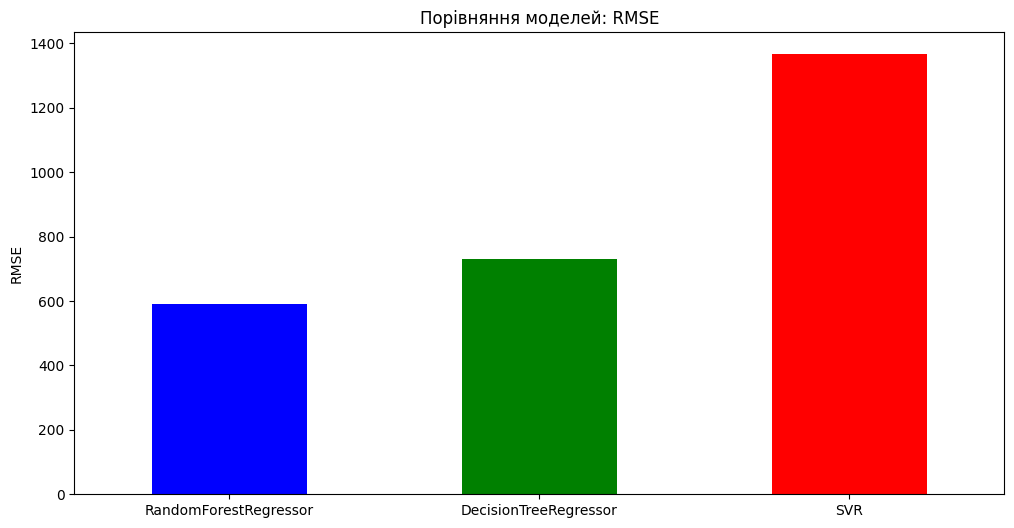

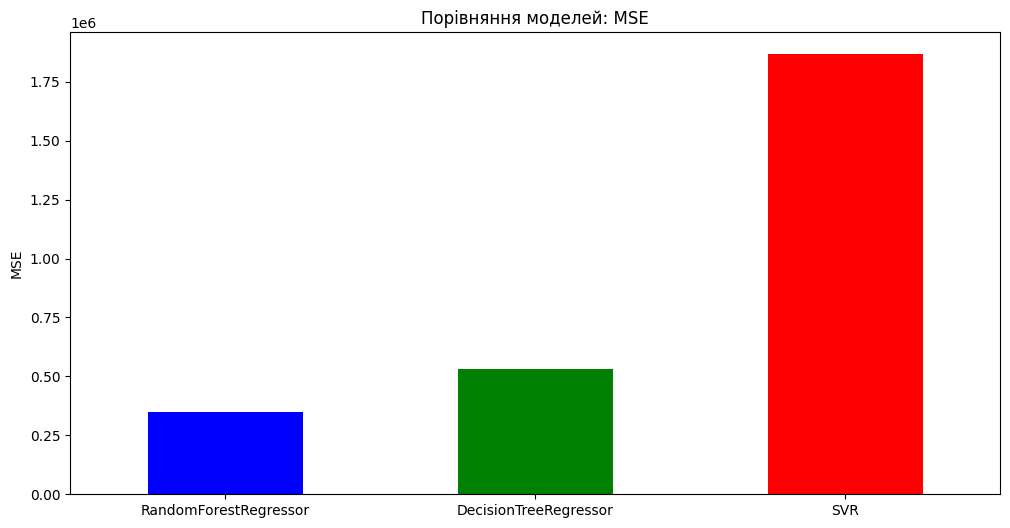

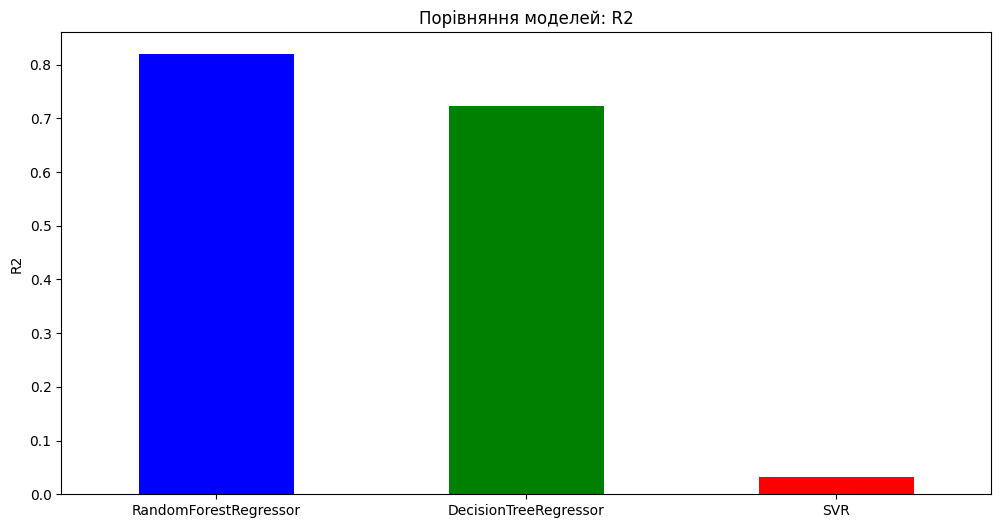

In [52]:
# Функція для побудови та оцінки моделі
def build_and_evaluate_model(model):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return rmse, mse, r2


# Опис моделей
models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'SVR': SVR(kernel='rbf')
}

# Збираємо результати
results = {}
for model_name, model in models.items():
    rmse, mse, r2 = build_and_evaluate_model(model)
    results[model_name] = {'RMSE': rmse, 'MSE': mse, 'R2': r2}

# Перетворюємо результати в DataFrame
results_df = pd.DataFrame(results).T
print("Результати для кожної моделі:")
print(results_df)
# Створення 3 окремих графіків для кожного показника

# RMSE
plt.figure(figsize=(12, 6))
results_df['RMSE'].plot(kind='bar', color=['b', 'g', 'r'])
plt.title('Порівняння моделей: RMSE')
plt.ylabel('RMSE')
plt.xticks(rotation=0)
plt.show()

# MSE
plt.figure(figsize=(12, 6))
results_df['MSE'].plot(kind='bar', color=['b', 'g', 'r'])
plt.title('Порівняння моделей: MSE')
plt.ylabel('MSE')
plt.xticks(rotation=0)
plt.show()

# R2
plt.figure(figsize=(12, 6))
results_df['R2'].plot(kind='bar', color=['b', 'g', 'r'])
plt.title('Порівняння моделей: R2')
plt.ylabel('R2')
plt.xticks(rotation=0)
plt.show()

RandomForestRegressor є найкращою моделлю серед трьох для прогнозування цін на основі даних, оскільки має найнижчі помилки і високе значення R².

знаходимо найкращі гіперпараметри для DecisionTreeRegressor, натренувати модель з оптимальними параметрами

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'model__max_depth': [3, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)


print(f"Найкращі гіперпараметри: {grid_search.best_params_}")


best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)


print(f"RMSE (оптимізована модель): {rmse_best}")
print(f"MSE (оптимізована модель): {mse_best}")
print(f"R2 (оптимізована модель): {r2_best}")

Найкращі гіперпараметри: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}
RMSE (оптимізована модель): 454.11490612290464
MSE (оптимізована модель): 206220.34796301447
R2 (оптимізована модель): 0.8930107336505617


Оптимізація моделі через GridSearchCV дала значне покращення результатів.Покращення R² з 0.7237 до 0.8930 є суттєвим і означає, що тепер модель точніше передбачає ціну меблів. Також зниження RMSE і MSE вказує на зменшення прогнозних помилок.

оцінка стабільності та ефективності моделі за допомогою крос-валідації.

RMSE для кожного фолда: [ 695.11975819  799.27706819  574.54350113 1061.1766697   966.86283889]
Середній RMSE: 819.3959672173032
Стандартне відхилення RMSE: 176.63887607758096


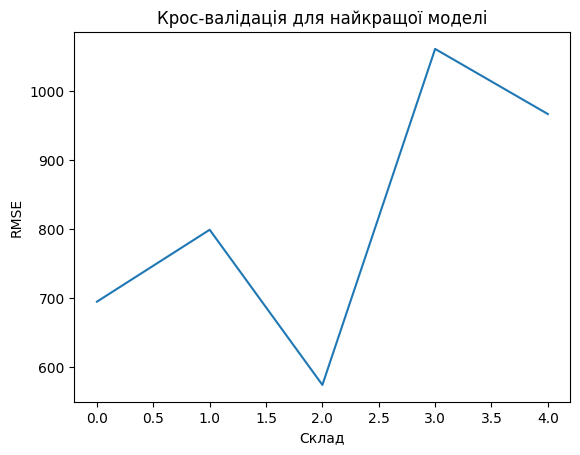

In [54]:
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print("RMSE для кожного фолда:", cv_rmse)
print("Середній RMSE:", np.mean(cv_rmse))
print("Стандартне відхилення RMSE:", np.std(cv_rmse))


plt.plot(cv_rmse)
plt.title('Крос-валідація для найкращої моделі')
plt.ylabel('RMSE')
plt.xlabel('Склад')
plt.show()

Середній RMSE: 819.40

Це значення показує середню точність моделі по всіх фолдах. Значення в межах 819.40 вказує на те, що модель у середньому робить помилку близько 819 одиниць при прогнозуванні ціни.
модель потребує вдосконалення для підвищення її стабільності та точності.